In [315]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

## Model Configuration

In [316]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class ModelArgs:
    dim: int = 128
    n_layers: int = 4
    n_heads: int = 4
    n_kv_heads: Optional[int] = 2
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 32
    max_seq_len: int = 16 * 8

    epochs: int = 5_000    

model_config = ModelArgs()
print(model_config)

ModelArgs(dim=128, n_layers=4, n_heads=4, n_kv_heads=2, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-05, max_batch_size=32, max_seq_len=128, epochs=5000)


## Prepare Data

In [317]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


lines = open('./data/Shakespeare.txt', 'r').read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(f'Sentences: {dataset.shape[0]}')

model_config.vocab_size = len(vocab)

def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

Sentences: 1115394


## Define Models

### RMS Normalization 

- [Paper](https://arxiv.org/pdf/1910.07467.pdf)
- [Reference implementation](https://github.com/facebookresearch/llama/blob/54d44631054deae836aec8ceff92dcf8f20ca9e7/llama/model.py#L34)

In [318]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x : torch.tensor) -> torch.tensor:
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x) -> torch.tensor:
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """        
        return self._norm(x.float()).type_as(x) * self.weight

### RoPE

- [Paper](https://arxiv.org/pdf/2104.09864.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L80)

In [319]:
class RoPE:
    def __init__(self, dim: int, max_seq_len: int, theta: float = 10000.0):
        """
        Precompute the frequency tensor for complex exponentials (cis, defined as 'm*theta_i' in the paper) 
        with given dimensions.

        Calculates a frequency tensor with complex exponentials using the given dimension 'dim'
        and the max sequence length. The 'theta_base' parameter scales the frequencies.
        The returned tensor contains complex values in complex64 data type.

        Args:
            dim (int): Dimension of the frequency tensor.
            max_seq_len (int): Max sequence length.
            theta_base (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.
        """
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        freqs = torch.outer(torch.arange(max_seq_len), freqs).float()
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
        print(f'Initialized RoPE with shape {self.freqs_cis.shape}')
        
    def __call__(self, x: torch.Tensor, start_pos = 0) -> torch.Tensor:
        """
        Apply rotary embeddings to input tensors using the given frequency tensor.

        This function first reshapes the frequency tensor to have the same shape as the target tensor 'x'
        for the purpose of broadcasting the frequency tensor during element-wise operations. Then, it applies 
        rotary embeddings to 'x' tensor using frequency tensor 'freqs_cis'.         
        """
        x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))

        freqs_cis = self.freqs_cis[start_pos:start_pos + x.shape[-2]]
                
        x_real = torch.view_as_real(x_complex * freqs_cis).flatten(-2)
        
        return x_real.type_as(x)

#### RoPE Test

In [320]:
dim = 128
max_seq_len = 256

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*i / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(max_seq_len, dim)

X= torch.ones(1, max_seq_len, dim)
rope = RoPE(dim=dim, max_seq_len=max_seq_len)
X1 = rope(X)
X2 = (R @ X.unsqueeze(-1)).flatten(-2)

print(X1.allclose(X2, atol=1e-3))


Initialized RoPE with shape torch.Size([256, 64])
True


### Feed-Forward Networks with SwiGLU

- [Paper](https://arxiv.org/pdf/2002.05202.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L307)

In [321]:
from typing import Optional

class FFN_SwiGLU(nn.Module):
    def __init__(
            self,
            config: ModelArgs,
        ):
        """
        Args:
            dim (int): Input dimension.
            hidden_dim (int): Hidden dimension of the feedforward layer.
            multiple_of (int): Value to ensure hidden dimension is a multiple of this value.
            ffn_dim_multiplier (float, optional): Custom multiplier for hidden dimension. Defaults to None.

        Attributes:
            w1 (ColumnParallelLinear): Linear transformation for the first layer.
            w2 (RowParallelLinear): Linear transformation for the second layer.
            w3 (ColumnParallelLinear): Linear transformation for the third layer.

        """
        super().__init__()
        hidden_dim = (config.dim * 4) * 2 // 3
        # custom dim factor multiplier
        if config.ffn_dim_multiplier is not None:
            hidden_dim = config.ffn_dim_multiplier * hidden_dim
        hidden_dim = config.multiple_of * ((hidden_dim + config.multiple_of - 1) // config.multiple_of)

        self.w = nn.Linear(config.dim, hidden_dim, bias=False)
        self.v = nn.Linear(config.dim, hidden_dim, bias=False)
        self.w_2 = nn.Linear(hidden_dim, config.dim, bias=False)

    def forward(self, x):
        return self.w_2(F.silu(self.w(x)) * self.v(x))

### Attention

*Note:* 2 differences with the [original Llama implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L176)
- The weight matrix has 3 dimensions as: `(number_head * model_dimension * head_dimension)` instead of `(model_dimension * model_dimension)`. This is strictly follow the "Attention is all you need" paper
- For Group Query Attention implmentation, instead of repeating KV values which is against the purpose of GQA (to reduce KV load overhead). Here reshapes the Q/K/V to 5 dimensions: `(batch_size * number_kv_heads * number_shared_kv (number_heads/number_kv_heads) * sequence_length * head_dimension)` and do matmut()

In [322]:
class Attention(nn.Module):
    """Multi-head attention module."""

    shared_rope : RoPE = None    

    def __init__(self, config : ModelArgs):
        super().__init__()
        self.config = config
        self.head_dim = config.dim // config.n_heads
        self.n_kv_heads = config.n_heads if config.n_kv_heads is None else config.n_kv_heads
        
        if Attention.shared_rope is None:
            Attention.shared_rope = RoPE(self.head_dim, config.max_seq_len)

        self.w_q = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_k = nn.Parameter(nn.init.kaiming_normal_(torch.empty(self.n_kv_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_v = nn.Parameter(nn.init.kaiming_normal_(torch.empty(self.n_kv_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_o = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads * self.head_dim, config.dim),
                                                        mode='fan_out', nonlinearity='relu'))

        self.cache_k = torch.zeros(config.max_batch_size, config.n_kv_heads, config.max_seq_len, self.head_dim, requires_grad=False)
        self.cache_v = torch.zeros_like(self.cache_k, requires_grad=False)
        self.dropout = nn.Dropout(.1)

    def forward(self, x: torch.tensor, start_pos : int) -> torch.tensor:
        """
        x: (batch_size, seq_len, dim)
        q: (batch_size, n_heads, seq_len, head_dim)
        k: (batch_size, n_heads, seq_len, head_dim)
        v: (batch_size, n_heads, seq_len, head_dim)
        """
        q = x.unsqueeze(1) @ self.w_q
        k = x.unsqueeze(1) @ self.w_k
        v = x.unsqueeze(1) @ self.w_v

        q = Attention.shared_rope(q, start_pos)
        k = Attention.shared_rope(k, start_pos)

        if self.training:       # apply dropout only during training
            dropout_p = 0.1            
        else:            
            self.cache_k[:, :, start_pos:start_pos + x.shape[-2]] = k
            self.cache_v[:, :, start_pos:start_pos + x.shape[-2]] = v        
            k = self.cache_k[:, :, :start_pos + x.shape[-2]]
            v = self.cache_v[:, :, :start_pos + x.shape[-2]]

            dropout_p = 0
        
        if x.shape[-2] == 1:    # if only one token, then not causal            
            is_causal = False
        else:
            is_causal = True

        # split heads and reshape Q, K, V as (batch_size, kv_heads, n_heads//kv_heads, seq_len, head_dim)
        q = q.view(self.config.max_batch_size, self.config.n_kv_heads, -1, q.shape[-2], self.head_dim)
        k = k.view(self.config.max_batch_size, self.config.n_kv_heads, -1, k.shape[-2], self.head_dim)
        v = v.view(self.config.max_batch_size, self.config.n_kv_heads, -1, v.shape[-2], self.head_dim)
        
        o = F.scaled_dot_product_attention(q, k, v, dropout_p = dropout_p, is_causal = is_causal)
        o = o.permute(0, 3, 1, 2, 4).contiguous().view(o.shape[0], o.shape[3], -1)       # concatenate heads
        o = o @ self.w_o
        o = self.dropout(o)

        return o

In [323]:
from collections import OrderedDict

class Llama2Block(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config

        self.rms = RMSNorm(config.dim)

        self.attention = Attention(config)
        self.attention_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_swiglu = FFN_SwiGLU(config)

    def forward(self, x, start_pos) -> torch.tensor:
        x = x + self.attention(self.attention_norm(x), start_pos)
        out = x + self.ffn_swiglu(self.ffn_norm(x))

        return out

class Llama2(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        
        Attention.shared_rope = None    # clear the shared rope defined in Attention class

        self.config = config
        self.embeddings = nn.Embedding(config.vocab_size, config.dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"LlamaBlock_{i}", Llama2Block(config)) for i in range(config.n_layers)])
        )
        self.norm = RMSNorm(config.dim)
        self.output = nn.Linear(config.dim, config.vocab_size, bias=False)

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, start_pos = 0, targets = None):
        h = self.embeddings(idx)

        for block in self.llama_blocks:
            h = block(h, start_pos)

        h = self.norm(h)
        logits = self.output(h)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

## Training

In [324]:
import pandas as pd
import time

@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model:Llama2):
    config = model.config
    out = {}
    is_training = model.training

    if is_training:
        model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config.max_batch_size, config.max_seq_len)
            _, loss = model(xb, 0, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    if is_training:
        model.train()

    return out

def train(model: Llama2, optimizer:torch.optim.Optimizer, scheduler = None, print_logs = False, log_interval = 100):
    losses = []
    start_time = time.time()
    config = model.config
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config.max_batch_size, config.max_seq_len)
        _, loss = model(xs, 0, ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config.epochs - epoch)/log_interval :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())            

    print("validation loss: ", losses[-1]['val'])
    pd.DataFrame(losses).plot()
    
    return losses

Initialized RoPE with shape torch.Size([128, 16])
model params: 1001344


Epoch 0 | val loss 4.037 | Time 0.275 | ETA in seconds 13.752
Epoch 100 | val loss 2.419 | Time 14.681 | ETA in seconds 719.361
Epoch 200 | val loss 2.126 | Time 16.256 | ETA in seconds 780.292
Epoch 300 | val loss 1.954 | Time 16.983 | ETA in seconds 798.183
Epoch 400 | val loss 1.852 | Time 17.979 | ETA in seconds 827.011
Epoch 500 | val loss 1.792 | Time 18.148 | ETA in seconds 816.664
Epoch 600 | val loss 1.733 | Time 18.070 | ETA in seconds 795.079
Epoch 700 | val loss 1.698 | Time 18.497 | ETA in seconds 795.368
Epoch 800 | val loss 1.693 | Time 18.416 | ETA in seconds 773.456
Epoch 900 | val loss 1.648 | Time 18.731 | ETA in seconds 767.961
Epoch 1000 | val loss 1.642 | Time 18.020 | ETA in seconds 720.782
Epoch 1100 | val loss 1.627 | Time 18.133 | ETA in seconds 707.172
Epoch 1200 | val loss 1.623 | Time 19.219 | ETA in seconds 730.341
Epoch 1300 | val loss 1.603 | Time 18.140 | ETA in seconds 671.181
Epoch 1400 | val loss 1.604 | Time 18.175 | ETA in seconds 654.317
Epoch 150

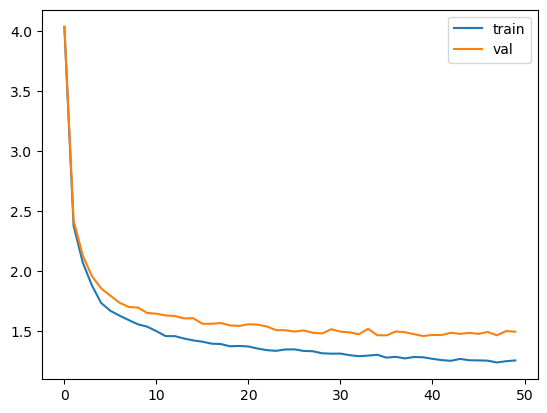

In [325]:
%%time

from datetime import datetime

llama = Llama2(model_config)
optimizer = torch.optim.Adam(llama.parameters())
losses = train(llama, optimizer, print_logs=True)


# Save
now = datetime.now()
model_name = f'./checkpoint/llama2_L{model_config.n_layers}xH{model_config.n_heads}xN{model_config.max_seq_len}xD{model_config.dim}_({losses[-1]["val"]:.3f})_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}.pth'
torch.save({'model_state_dict': llama.state_dict()}, model_name)

## Generate

In [326]:
@torch.no_grad()
def generate(model : Llama2, max_new_tokens = 10):
    model.eval()
    config = model.config
    max_new_tokens = model.config.max_seq_len if max_new_tokens > model.config.max_seq_len else max_new_tokens
    idx = torch.zeros(config.max_batch_size, 1).long()

    start_pos = 0
    for i in range(max_new_tokens):
        if i == 0:
            logits = model(idx)
        else:
            logits = model(idx[:, -1].unsqueeze(-1), start_pos)
            # logits = model(idx[:, -config.max_seq_len:], 0)
        
        last_time_step_logits = logits[:, -1, :]            # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)        # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )                                                   # sample from the distribution to get the next token

        start_pos = idx.shape[-1]
        idx = torch.cat([idx, idx_next], dim=-1)            # append to the sequence
                    
    return [decode(x) for x in idx.tolist()]

In [327]:
import glob
import os

## Get lastest checkpoint
files = glob.glob('./checkpoint/*.pth')
files.sort(key=os.path.getmtime)
model_name = files[-1]
print(f'Loading {model_name}')

llama_infer = Llama2(model_config)
llama_infer.load_state_dict(torch.load(model_name)['model_state_dict'])

Loading ./checkpoint/llama2_L4xH4xN128xD128_(1.492)_2023_11_17_15_51.pth
Initialized RoPE with shape torch.Size([128, 16])
model params: 1001344


<All keys matched successfully>

In [328]:
%%time

for s in generate(llama_infer, 128):
    print(s)


CORIOLANUS:
Wefze, so witning; I will not speak uponer. What, is your
called against my book with thee to last, and point:
And w

Clout, and forfeit for way; where aught
The shrung I sunders from him, our niederer!
And, all the tongue is matters: know, God, 

And which so. fought!

BENVOLIO:
Nay, naught!

SICINIUS:
I may believe your news with serve me that and large
Look on the palema


HERMIONE:
ARCHat Edward are no sleep'st for fair people.

CLIFFORD:
And take you am had of your necks.
Go, my forerest of my br

I do show and with the end, and felly news
Enclaimed by that hit with the traitors:

I may come do an hour senators, do the braw

Whose sworn, and not not to horse;
For, I hope hold me and these next-wans' wish;
Lest to dangenet with sacrel of such,
And like

GLOUCESTER:
I will be knees in the head the gold rest, for
whose word as the centracts of two friends of joy
England, bed put me

Doth vether with 'sis a barely?

RATCLIFF:
If to destroy but I do live you are no crown,
